In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm
from pprint import pprint
import time
from copy import deepcopy

import os
os.chdir(r"/Users/daniekru/Research/lab/PCNN/")
import main
import src.models as mm
from src.models import logger
from src.minimal_model import minPCNN, fullPCNN, Policy
import src.minimal_model as minm
import src.visualizations as vis
import src.utils as utils
import inputools.Trajectory as it
from tools.utils import clf, tqdm_enumerate, save_image, AnimationMaker

### Parameters

In [2]:
""" PARAMETERS """

# parameters
duration = 20
seed = 4329
online = False
lr = 0.2
tau = 200
ach_threshold = 0.3
save = False
show = True
animate = False
verbose = True

N = 200
Nj = 25**2

params = {
    "N": N,
    "Nj": Nj,
    "tau": 10.0,
    "alpha": 0.2, # ! <----
    "beta": 20.0,
    "lr": lr,
    "threshold": 0.02,
    "ach_threshold": ach_threshold,
    "da_threshold": 0.5,
    "tau_ach": 200.,  # 2.
    "eq_ach": 1.,
    "tau_da": tau,  # 2.
    "eq_da": 0.,
    "epsilon": 0.4,
}

np.random.seed(seed)

### train 1
---

In [3]:
""" 1st TRAINING """

# make trajectory
trajectory, whole_track, inputs, whole_track_layer, layer = main.make_trajectory(
                        plot=False,
                        Nj=Nj,
                        duration=duration,
                        is2d=True,
                        sigma=0.004)
logger(">>> trajectory 1")

2024-09-05 13:56:17 | >>> trajectory 1


In [4]:
model = minPCNN(**params)
if verbose:
    logger(f"%{model}")
    logger("training 1...")

# train
for t, x in tqdm_enumerate(inputs, disable=not verbose):
    model.step(x=x.reshape(-1, 1))
    # if t % 100:
    #     model.clear_connections()


#
old_model = deepcopy(model)
logger(">>> `old_model`")

2024-09-05 13:56:17 | %minPCNN(N=200, Nj=625, lr=0.2)
2024-09-05 13:56:17 | training 1...
100%|███████████████████████████████████████████████████████████████████████████████████████████| 19200/19200 [00:44<00:00, 432.77it/s]
2024-09-05 13:57:02 | >>> `old_model`


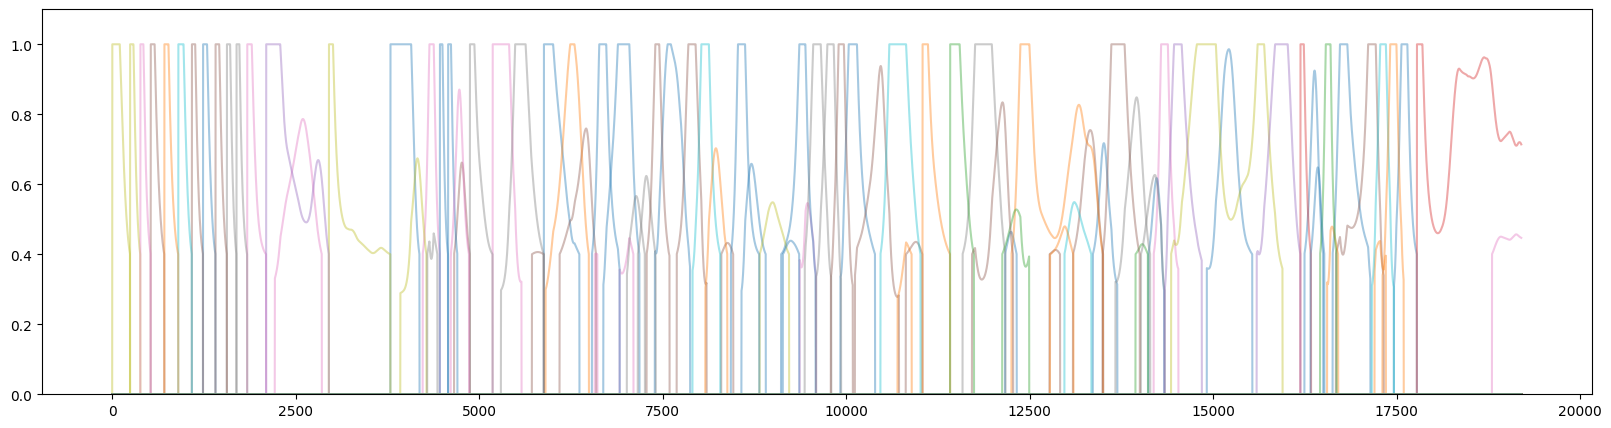

In [6]:
plt.figure(figsize=(20, 5))
length = len(np.array(model._activity['u'])[:, 0])
u_arr = np.array(model._activity['u'])
for i in range(N):
    plt.plot(range(length), 
             u_arr[:, i], alpha=0.4)

plt.ylim(0, 1.1)
plt.show()

### train 2
---

In [ ]:
# make trajectory
trajectory, whole_track, inputs, whole_track_layer, layer = main.make_trajectory(
                        plot=False,
                        Nj=Nj,
                        duration=duration*1,
                        is2d=True,
                        sigma=0.004)
logger(">>> trajectory 2")

In [6]:
### policy
startime = 200
trg = np.array([0.5, 0.5])
policy = Policy(eq_da=1.,
                trg=trg,
                threshold=0.3,
                startime=startime)

online = False
if online:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    da = []
    ach = []
    dwd = []
    umax = []
    ax1.scatter(trg[0], trg[1], c='g', s=20, alpha=0.8, marker='x')

if animate:
    animation_maker = AnimationMaker(fps=7, use_logger=True,
                                     path=ANIM_PATH)

In [7]:
if verbose:
    logger(f"%{policy}")
    logger("training 2...")

#
#model = deepcopy(old_model)

#
umax = []
ft = []
umask0 = model._umask.copy()
tper = 1000

model.unfreeze()
for t, x in tqdm_enumerate(inputs, disable=not verbose):
    eq_da = policy(pos=trajectory[t, :], t=t)
    model(x=x, eq_da=eq_da)

    # - calc nodes
    idxs = np.where(model._umask - umask0)[0]
    umask0 = model._umask.copy()
    if len(idxs) > 0:
        ft += [[trajectory[t, 0], trajectory[t, 1]]]
        model.add_center(center=[trajectory[t, 0], trajectory[t, 1]],
                         idx=idxs[0])

    # online plot
    if online:
        da += [model._DA]
        ach += [model._ACh]
        dwd += [model.dwda.max()]
        umax += [model.u.max()]
        if len(da) > 1000:
            del da[0]
            del ach[0]
            del dwd[0]
            del umax[0]

        if t % tper == 0:
            # model.clear_connections(epsilon=0.05)
            centers2, connections2, nodes2, edges2 = make_centers(model=model,
                            trajectory=trajectory,
                            whole_track=whole_track,
                            whole_track_layer=whole_track_layer,
                            plot=False, show=False, color='black',
                            verbose=False,
                            alpha=0.95,
                            ax=ax)

            model.unfreeze()

            online_plot(t=t, tper=tper, model=model,
                        trajectory=trajectory,
                        policy_eq=eq_da,
                        policy_time=startime, with_policy=True,
                        ax1=ax1, ax2=ax2, fig=fig,
                        umax=umax, da=da, ach=ach,
                        dwd=dwd,
                        centers=centers2,
                        connections=connections2,
                        plot_trajectory=True,
                        show=True)

            if animate:
                animation_maker.add_frame(fig)

# --- PLOT 2
# --- with old pc estimate
if verbose:
    logger("plotting 2...")

if online:
    plt.close()
    fig, ax = plt.subplots()
    fig.suptitle(f"$\eta=${lr} - $\\tau=${args.tau} - " + \
                 f"$\\theta_{{ach}}$={ach_threshold} - " + \
                 f"$\\theta_{{da}}$={params['da_threshold']}")

if animate:
    animation_maker.make_animation(name=f"roaming_{time.strftime('%H%M%S')}")
    logger(f"animation saved at {ANIM_PATH}")
    animation_maker.play_animation(return_Image=False)

2024-08-30 02:21:36 | %Policy(eq_da=1.0, trg=[0.5 0.5], startime=200ms)
2024-08-30 02:21:36 | training 2...
100%|███████████████████████████████████████████████████████████████████████████████████████████| 19200/19200 [00:52<00:00, 364.59it/s]
2024-08-30 02:22:29 | plotting 2...


In [ ]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.imshow(model._Wff, aspect='auto', vmin=0., vmax=0.3)
plt.colorbar()
plt.title("new model")
plt.subplot(122)
plt.imshow(old_model._Wff, aspect='auto',
           vmin=0., vmax=0.3)
plt.colorbar()
plt.title("old model")
plt.show()

In [10]:
centers2, connections2, nodes2, edges2 = main.make_centers(model=model,
                trajectory=trajectory,
                whole_track=whole_track,
                whole_track_layer=whole_track_layer,
                plot=False, show=False, color='black',
                verbose=verbose,
                alpha=0.95,
                ax=None)

if verbose:
    logger(f"{len(centers2)} place cells")

# nodes = nodes1 * nodes2

# print(connections1.shape, connections2.shape)
# print(nodes1.shape, nodes2.shape, nodes.shape)

# centers 2 for each actual node, final shape
# is matches the total number of neurons
# centers = []
# idxn = 0
# idxe = 0
# connections = []
# for i, (n2, n) in enumerate(zip(nodes2, nodes)):
#     if n2 > 0:
#         if n > 0:
#             centers += [centers2[idxn].tolist()]
#             connections += [connections1[idxe].tolist()]
#             idxe += 1
#         idxn += 1

# centers = np.array(centers)
# connections = np.array(connections)

connections0 = connections2.copy()

# logger.debug(f"{connections0.shape} {connections1.shape} {connections2.shape}")

for i in range(min((len(centers1), len(centers2)))):
    if nodes1[i] > 0:
        for j in range(min((len(connections1[i]), len(connections2[i])))):
            connections0[i, j] = connections1[i, j]

# print("final graph: ", centers.shape, connections.shape)
fig, ax = plt.subplots()
fig.suptitle(f"$\eta=${lr} - $\\tau=${tau} - " + \
             f"$\\theta_{{ach}}$={ach_threshold} - " + \
             f"$\\theta_{{da}}$={params['da_threshold']}")

# plot
ax.scatter(trg[0], trg[1], c='g', s=40, alpha=0.8,
           marker='x',
           label="target")
vis.plot_graph(centers=centers1,
               connectivity=connections1,
               ax=ax, alpha=1., color="black",
               marker='o',
               label="old centers",
               plot_connections=True,
               plot_centers=True)
vis.plot_graph(centers=centers2,
               connectivity=connections2,
               ax=ax, alpha=0.8, color="green",
               marker='v',
               label="new centers",
               plot_connections=True,
               plot_centers=True)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', 'box')

ax.set_title(f"{len(centers1)} PCs")
plt.legend()

if save:
    plt.savefig(f"media/online_{lr}_{tau}.png")
    plt.close()
elif show:
    plt.show()
plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40401/40401 [00:01<00:00, 27300.04it/s]
2024-08-29 15:59:40 | 43 place cells


NameError: name 'centers1' is not defined

---

In [49]:
w = model._Wff.copy()

In [50]:
w0 = w / np.linalg.norm(w, axis=1, keepdims=1)
w0 = np.where(np.isnan(w0), 0, w0)
w1 = w0 @ w0.T - np.eye(w0.shape[0])
#w1 = np.where(w1 > 0.7, w1, 0)

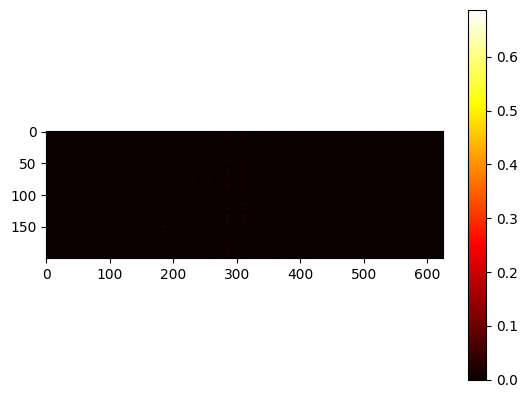

In [51]:
plt.imshow(w, cmap='hot', vmin=0, vmax=w1.max())
plt.colorbar();

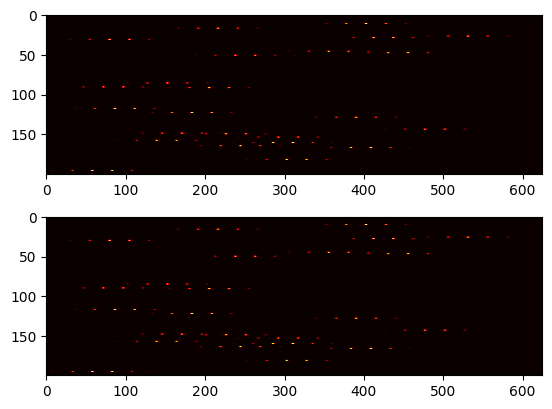

In [18]:
plt.subplot(211)
plt.imshow(model._Wff, cmap='hot', vmin=0, vmax=0.1)
plt.subplot(212)
plt.imshow(old_model._Wff, cmap='hot', vmin=0, vmax=0.1)
plt.show()

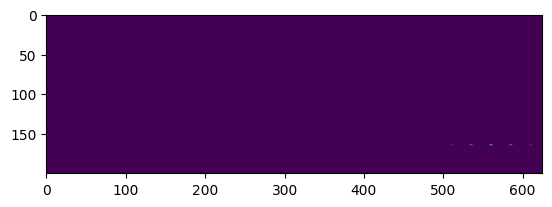

In [10]:
plt.imshow(model._Wff - old_model._Wff);

In [53]:
m = model._Wff.copy()

m /= np.linalg.norm(m, axis=1, keepdims=True)
m = np.where(np.isnan(m), 0, m)
m = m @ m.T * (1- np.eye(m.shape[0]))

m = np.max(m, axis=1)
m = np.where(m < 0.07, 1., 0).reshape(-1, 1)
print(m.T)

minm.calc_repulsion(model._Wff, 0.5).T

[[1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.
  1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
  1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 1. 1. 1.]]


array([[1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1.]])

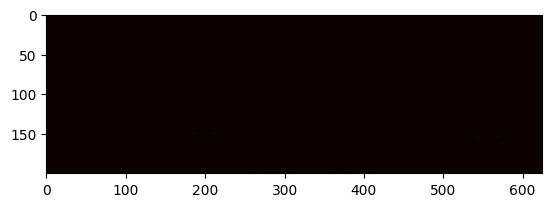

In [54]:
plt.imshow((model._Wff * minm.calc_repulsion(model._Wff, 0.9) - model._Wff)**2,
           cmap='hot', vmin=0, vmax=0.1);

In [55]:
# normalized matrix dot product
M = w / np.linalg.norm(w, axis=1, keepdims=True)
M = np.where(np.isnan(M), 0., M)
repulsion = M @ M.T

#repulsion = np.max(repulsion, axis=1)


In [56]:
model.dwda.max()

0.0

In [61]:
(layer, model)

(Layer(N=625, kind=`place`), minPCNN(N=200, Nj=625, lr=0.05))

In [20]:
z = model._Wff[2]
X = layer.centers[:, 0]
Y = layer.centers[:, 1]

---

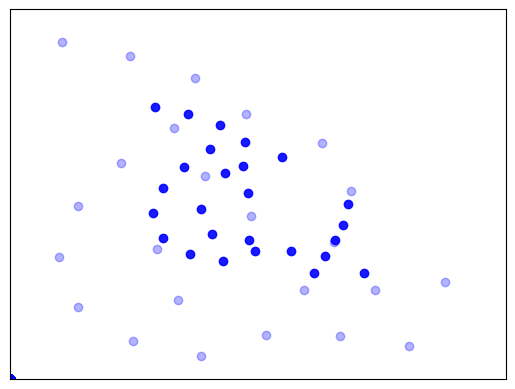

In [8]:
def plot_c(W, layer, color="blue", alpha=1, show=True):
    X = layer.centers[:, 0]
    Y = layer.centers[:, 1]
    
    x = (W * X).sum(axis=1) / W.sum(axis=1)
    y = (W * Y).sum(axis=1) / W.sum(axis=1)
    
    x = np.where(np.isnan(x), 0, x)
    y = np.where(np.isnan(y), 0, y)
    
    plt.scatter(x, y, color=color, alpha=alpha)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xticks(())
    plt.yticks(())
    if show:
        plt.show()

plot_c(W=model._Wff, layer=layer, show=False, alpha=0.9) # new
plot_c(W=old_model._Wff, layer=layer, alpha=0.3) # old

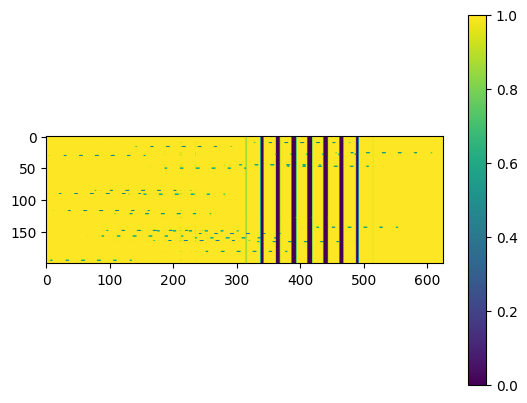

In [21]:
x = inputs[100].reshape(1, -1)
dw = np.exp(-((model._Wff - x)**2)/0.00001)
plt.imshow(dw)
plt.colorbar();

In [8]:
model.rps.T

array([[0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

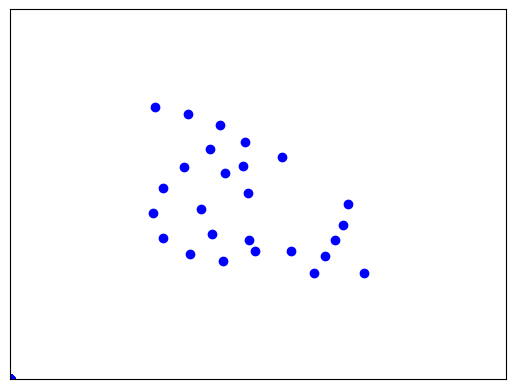

In [9]:
plot_c(W=model._Wff, layer=layer)

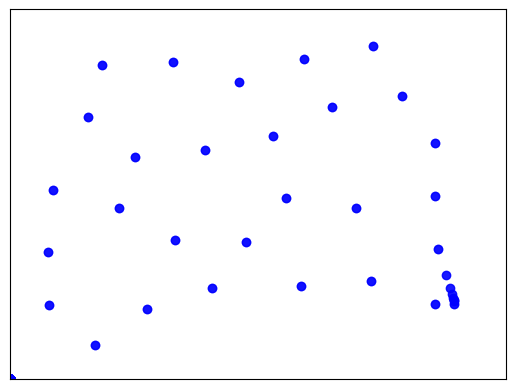

In [29]:
plot_c(W=model._Wff, layer=layer, show=False, alpha=0.9) # new
plot_c(W=old_model._Wff, layer=layer, alpha=0.3) # old

In [22]:
help(utils.generalized_sigmoid)

Help on CPUDispatcher in module src.utils:

generalized_sigmoid(x: numpy.ndarray, alpha: float, beta: float, clip_min: float) -> numpy.ndarray
    generalized sigmoid function and set values below
    a certain threshold to zero.
    
    Parameters
    ----------
    x : np.ndarray
        The input array.
    alpha : float
        The alpha parameter.
    beta : float
        The beta parameter.
    clip_min : float
        The minimum value to clip.
    
    Returns
    -------
    np.ndarray
        The output array.



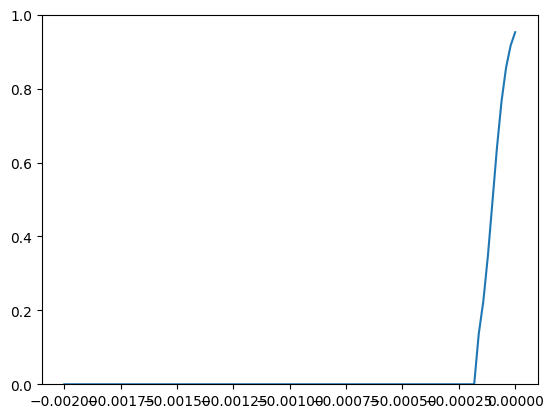

In [19]:
X = np.linspace(0, 0.002, 100)
plt.plot(-X, utils.generalized_sigmoid(x=X, beta=-30_000, alpha=0.0001, clip_min=0.1))
plt.ylim(0, 1)
plt.show()

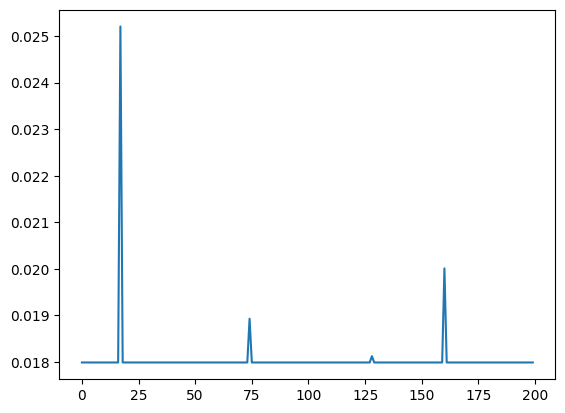

In [12]:
plt.plot(model.u);

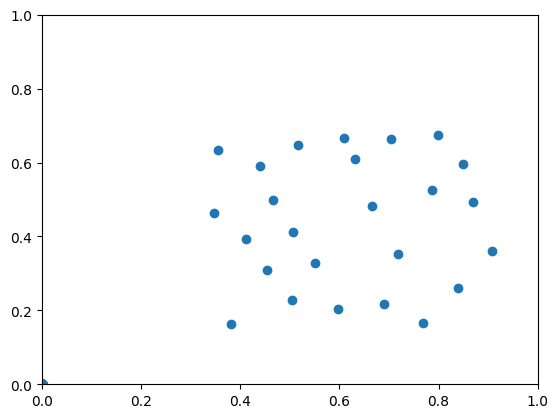

In [46]:
plt.scatter(x, y)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

In [16]:
M = model._Wff.copy()

M = M / np.linalg.norm(M, axis=1, keepdims=True)
M = np.where(np.isnan(M), 0., M)
repulsion = (M @ M.T) * (1 - np.eye(M.shape[0]))

repulsion = np.max(repulsion, axis=0)

repulsion

array([0.99968894, 0.        , 0.        , 0.07769653, 0.        ,
       0.        , 0.        , 0.        , 0.82810092, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99968894,
       0.        , 0.07796003, 0.        , 0.07500284, 0.        ,
       0.99499677, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.99934603, 0.        , 0.07807752, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07731153, 0.99483322, 0.        , 0.        ,
       0.        , 0.07739064, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07642605, 0.        , 0.        ,
       0.07813344, 0.        , 0.        , 0.73835331, 0.     

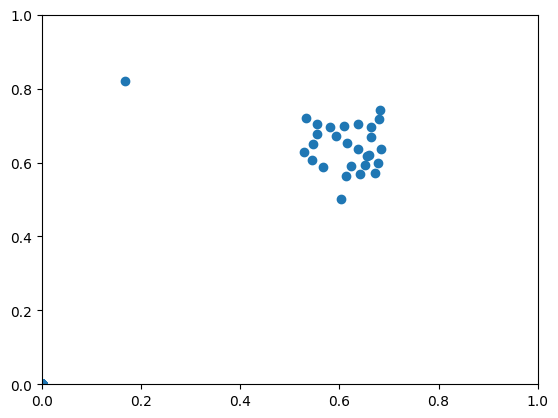

In [33]:
z = model._Wff[2]
X = layer.centers[:, 0]
Y = layer.centers[:, 1]

x = (model._Wff * X).sum(axis=1) / model._Wff.sum(axis=1)
y = (model._Wff * Y).sum(axis=1) / model._Wff.sum(axis=1)

x = np.where(np.isnan(x), 0, x)
y = np.where(np.isnan(y), 0, y)

plt.scatter(x, y)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

---
inverse gaussian
$$
\begin{align*}
f(x)&=a\cdot\exp{\left(-\left(\frac{x-b}{2*c}\right)^{2}\right)}\\\\
f^{-1}(y)&=b\pm c\cdot\sqrt{-2*ln\left(\frac{y}{a}\right)}
\end{align*}
$$

In [111]:
def inverse(z, b, c):
    return b + c * np.sqrt(-2*np.log(z, axis=1))

In [127]:
x = inverse(model._Wff, layer.centers[:, 0], 1).sum(axis=1)
y = inverse(model._Wff, layer.centers[:, 1], 1).sum(axis=1)
x.shape

(200,)

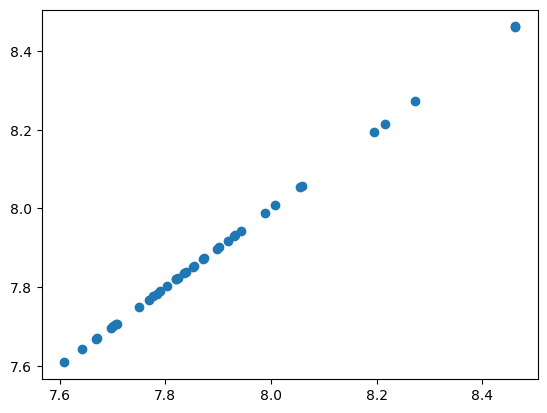

In [125]:
plt.scatter(x, y);

In [128]:
x

array([          inf,           inf, 4776.31341055,           inf,
       5134.57579723,           inf,           inf,           inf,
                 inf,           inf, 4919.8720417 ,           inf,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf, 4755.44206283,
                 inf,           inf,           inf, 4860.78623334,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf,           inf,
       4956.26847845,           inf,           inf,           inf,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf, 5288.7763161 ,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf,           